In [0]:
import librosa
import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
import itertools


from scipy import signal as sg

#function to find the fundamental pitch frequency counting zeroes
#From https://www.kaggle.com/asparago/simple-pitch-detector
def find_fundamental(y, sr):
  signal = y
  #one should be careful in deciding if it is worth analysing the entire record or
  #just chunks of it, and excluding more noisy parts  
  #signal=signal[:len(signal)/2]
  rate = sr #wf.getframerate()
  swidth = len(y) # wf.getsampwidth()
  #first of all we remove the horizontal offset
  signal = signal - np.mean(signal)
  #now we calculate the autocorrelation of the signal against itself but inverted in time
  #and we throw away negative lags
  corr = sg.fftconvolve(signal, signal[::-1], mode='full')
  corr = corr[int(len(corr)/2):]
  diff = np.diff(corr)
  n = [i for i in range(0,len(diff)) if diff[i]>0][0]
  peak = np.argmax(corr[n:]) + n
  return rate/peak


def graph_wav(name, title=""):
  # read audio samples
  input_data = read(name)
  audio = input_data[1]
  # plot the first 1024 samples
  plt.plot(audio[0:1024])
  # label the axes
  plt.ylabel("Amplitude")
  plt.xlabel("Time")
  # set the title  
  plt.title(title)
  # display the plot
  plt.show()

def correlation_coefficient(T1, T2):
    numerator = np.mean((T1 - T1.mean()) * (T2 - T2.mean()))
    denominator = T1.std() * T2.std()
    if denominator == 0:
        return 0
    else:
        result = numerator / denominator
        return result

def get_factorizacion(file_name, n_components):
  y, sr = librosa.load(file_name)
  S1 = librosa.stft(y)
  S = np.abs(S1)
  T = sklearn.decomposition.MiniBatchDictionaryLearning(n_components=n_components)
  comps, acts = librosa.decompose.decompose(S, transformer=T, n_components=n_components, sort=True)
  return y, sr, S, comps, acts  

def separate(test_name, audio1, audio2, n_components):
  test_name = test_name + "{}.wav"

  y, sr, S1_ff, comps, acts = get_factorizacion(audio1, n_components)
  audio1S = np.abs(S1_ff)

  S_approx = comps.dot(acts)
  resultado = librosa.istft(S_approx)
  librosa.output.write_wav(test_name.format("_resultado_a"), resultado, sr)

  y, sr, S2_ff, comps, acts = get_factorizacion(audio2, n_components)
  audio2S = np.abs(S2_ff)

  S_approx = comps.dot(acts)
  resultado = librosa.istft(S_approx)
  librosa.output.write_wav(test_name.format("_resultado_b"), resultado, sr)
  
  file_name = test_name.format("")
  y, sr, S, comps, acts = get_factorizacion(file_name, n_components)

  S_approx = comps.dot(acts)
  resultado = librosa.istft(S_approx)
  librosa.output.write_wav(test_name.format("_resultado"), resultado, sr)

  graph_wav(test_name.format("_resultado"),   'Original Flauta y Guitarra')
  graph_wav(test_name.format("_resultado_a"), 'Original Flauta')
  graph_wav(test_name.format("_resultado_b"), 'Original Guitarra')

  max_1 = 0
  max_2 = 0
  max_1_wav = []
  max_2_wav = []
  
  for size in range(1, n_components-1):
    for components_to_delete in itertools.combinations(range(0, n_components), size):
      actuscopu = acts.copy()
      
      for component in components_to_delete:
        actuscopu[component, :] = 0

      S_approx = comps.dot(actuscopu)

      c1 = correlation_coefficient(audio1S, S_approx)
      c2 = correlation_coefficient(audio2S, S_approx)

      if max_1 < c1:
        max_1 = c1
        max_1_wav = ["Reconstruido Flauta", S_approx]

      if max_2 < c2:
        max_2 = c2
        max_2_wav = ["Reconstruido Guitarra", S_approx]

  name = test_name.format("resultado_a")
  resultado = librosa.istft(max_1_wav[1])
  librosa.output.write_wav(name, resultado, sr)
  graph_wav(name, max_1_wav[0])
  name = test_name.format("resultado_b")
  resultado = librosa.istft(max_2_wav[1])
  librosa.output.write_wav(name, resultado, sr)
  graph_wav(name, max_2_wav[0])





#print(find_fundamental(y, sr))

In [0]:
# a => trumpet_A4_long_pianissimo_normal
# b => violin_D4_15_piano_arco-normal
separate('../Audios/test_1_mix','../Audios/test_1_a.wav','../Audios/test_1_b.wav', 6)

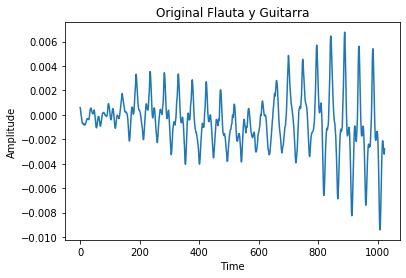

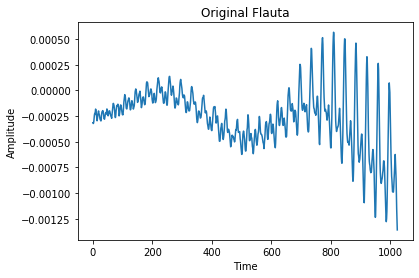

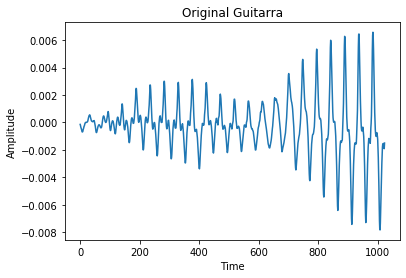

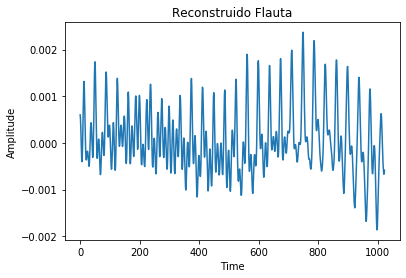

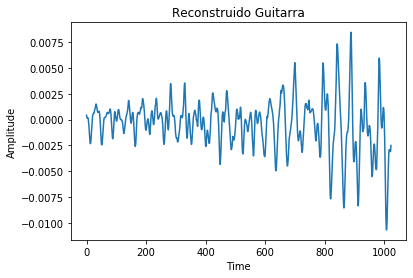

In [7]:
# a => flute_D5_1_mezzo-piano_normal
# b => guitar_As4_very-long_piano_normal
# Al primer nombre lo guarda en files con "resultados...." al final
separate('../Audios/test_2_mix','../Audios/test_2_a.wav','../Audios/test_2_b.wav', 6)


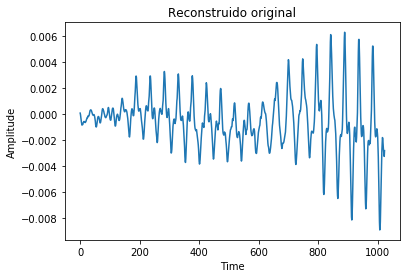

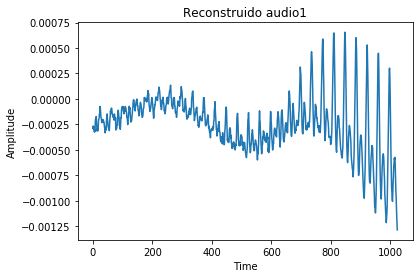

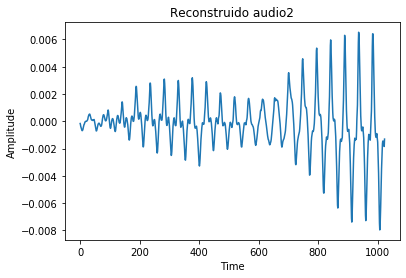

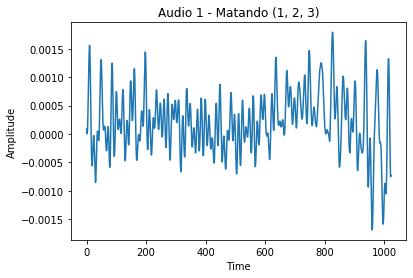

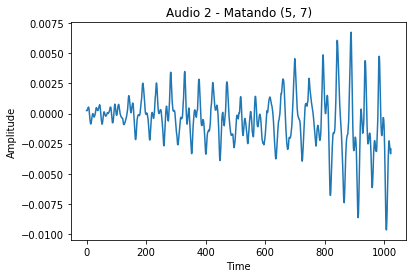

In [0]:
# a => flute_D5_1_mezzo-piano_normal
# b => guitar_As4_very-long_piano_normal
separate('tests/test_2_mix','./tests/test_2_a.wav','./tests/test_2_b.wav', 8)
